# ⚠️ You need to download the dataset from [here](https://www.kaggle.com/c/acea-water-prediction/data). Unzip the dataset and store it in the same directory as this notebook.
# ⚠️ According to kagglle competition rule 7.A, we do not allow the use of data sets outside the competition, so <span style="color:red;">please do not distribute the data sets</span>. For more information, please refer to [Acea Smart Water Analytics](https://www.kaggle.com/c/acea-water-prediction/rules).
# ⚠️ In large-scale ML projects, jupyter notebook is great for prototyping and sharing with visualization, but in subsequent development, you should build more specific data/model pipelines in scripts/modules to operate in order to reduce the technical debt to be repaid in the future.

## Import packages

In [1]:
# Standard library
using Dates
using Logging
using Printf

# Third party
using DataFrames
using ShiftedArrays
using CSV
using Chain
using Plots
using LaTeXStrings
using MLJ, MLJDecisionTreeInterface

ENV["COLUMNS"] = 500;

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342


## Basic helper functions

In [2]:
datadir(args...) = joinpath("acea-water-prediction", args...)

datadir (generic function with 1 method)

## Read the original data and simplify the data

In [3]:
df = CSV.read(datadir("Aquifer_Petrignano.csv"), DataFrame)
display(first(df, 5))
display(last(df, 5))
display(describe(df))

### Simplifications for the sake of the tutorial ###
@chain df begin
    # Drop data before 2009 for the purpose of this tutorial
    filter!(:Rainfall_Bastia_Umbra => x -> !ismissing(x), _)
    # Drop one of the target columns, so we can focus on only one target. And simplify column names.
    select!(
        :Date,
        :Rainfall_Bastia_Umbra => :Rainfall,
        :Temperature_Bastia_Umbra => :Temperature,
        :Volume_C10_Petrignano => :Drainage_Volume,
        :Hydrometry_Fiume_Chiascio_Petrignano => :River_Hydrometry,
        :Depth_to_Groundwater_P25 => :Depth_to_Groundwater,
    )
    # convert String to DateTime
    transform!(:Date => ByRow(x -> DateTime(chomp(x), DateFormat("dd/mm/yyyy"))), renamecols=false)
end

targets = ["Depth_to_Groundwater"]
features = [feature for feature in names(df) if feature ∉ targets]


display(first(df, 5))
display(describe(df))

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
,String15,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,14/03/2006,missing,-22.48,-22.18,missing,missing,missing,missing
2,15/03/2006,missing,-22.38,-22.14,missing,missing,missing,missing
3,16/03/2006,missing,-22.25,-22.04,missing,missing,missing,missing
4,17/03/2006,missing,-22.38,-22.04,missing,missing,missing,missing
5,18/03/2006,missing,-22.6,-22.04,missing,missing,missing,missing


,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
,String15,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?
1,26/06/2020,0.0,-25.68,-25.07,25.7,24.5,-29930.7,2.5
2,27/06/2020,0.0,-25.8,-25.11,26.2,25.0,-31333.0,2.4
3,28/06/2020,0.0,-25.8,-25.19,26.9,25.7,-32120.9,2.4
4,29/06/2020,0.0,-25.78,-25.18,26.9,26.0,-30602.9,2.4
5,30/06/2020,0.0,-25.91,-25.25,27.3,26.5,-31878.1,2.4


,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,Date,,01/01/2007,,31/12/2019,0,String15
2,Rainfall_Bastia_Umbra,1.55663,0.0,0.0,67.3,1024,"Union{Missing, Float64}"
3,Depth_to_Groundwater_P24,-26.2637,-34.47,-25.99,-19.66,55,"Union{Missing, Float64}"
4,Depth_to_Groundwater_P25,-25.6929,-33.71,-25.54,-19.1,39,"Union{Missing, Float64}"
5,Temperature_Bastia_Umbra,15.0303,-3.7,14.7,33.0,1024,"Union{Missing, Float64}"
6,Temperature_Petrignano,13.7391,-4.2,13.5,31.1,1024,"Union{Missing, Float64}"
7,Volume_C10_Petrignano,-29043.3,-45544.9,-28689.1,0.0,198,"Union{Missing, Float64}"
8,Hydrometry_Fiume_Chiascio_Petrignano,2.37252,0.0,2.4,4.1,1024,"Union{Missing, Float64}"


,Date,Rainfall,Temperature,Drainage_Volume,River_Hydrometry,Depth_to_Groundwater
,DateTime,Float64?,Float64?,Float64?,Float64?,Float64?
1,2009-01-01T00:00:00,0.0,5.2,-24530.7,2.4,-31.14
2,2009-01-02T00:00:00,0.0,2.3,-28785.9,2.5,-31.11
3,2009-01-03T00:00:00,0.0,4.4,-25766.2,2.4,-31.07
4,2009-01-04T00:00:00,0.0,0.8,-27919.3,2.4,-31.05
5,2009-01-05T00:00:00,0.0,-1.9,-29854.7,2.3,-31.01


,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,Type
1,Date,,2009-01-01T00:00:00,,2020-06-30T00:00:00,0,DateTime
2,Rainfall,1.55663,0.0,0.0,67.3,0,"Union{Missing, Float64}"
3,Temperature,15.0303,-3.7,14.7,33.0,0,"Union{Missing, Float64}"
4,Drainage_Volume,-28669.2,-41890.2,-28389.7,0.0,1,"Union{Missing, Float64}"
5,River_Hydrometry,2.37252,0.0,2.4,4.1,0,"Union{Missing, Float64}"
6,Depth_to_Groundwater,-25.1825,-33.71,-25.17,-19.1,27,"Union{Missing, Float64}"


Features:

- **Rainfall** indicates the quantity of rain falling (mm)
- **Temperature** indicates the temperature (°C)
- **Volume** indicates the volume of water taken from the drinking water treatment plant ($m^3$)
- **Hydrometry** indicates the groundwater level (m)

Target:

- **Depth to Groundwater** indicates the groundwater level (m from the ground floor)

### Plot simplified data

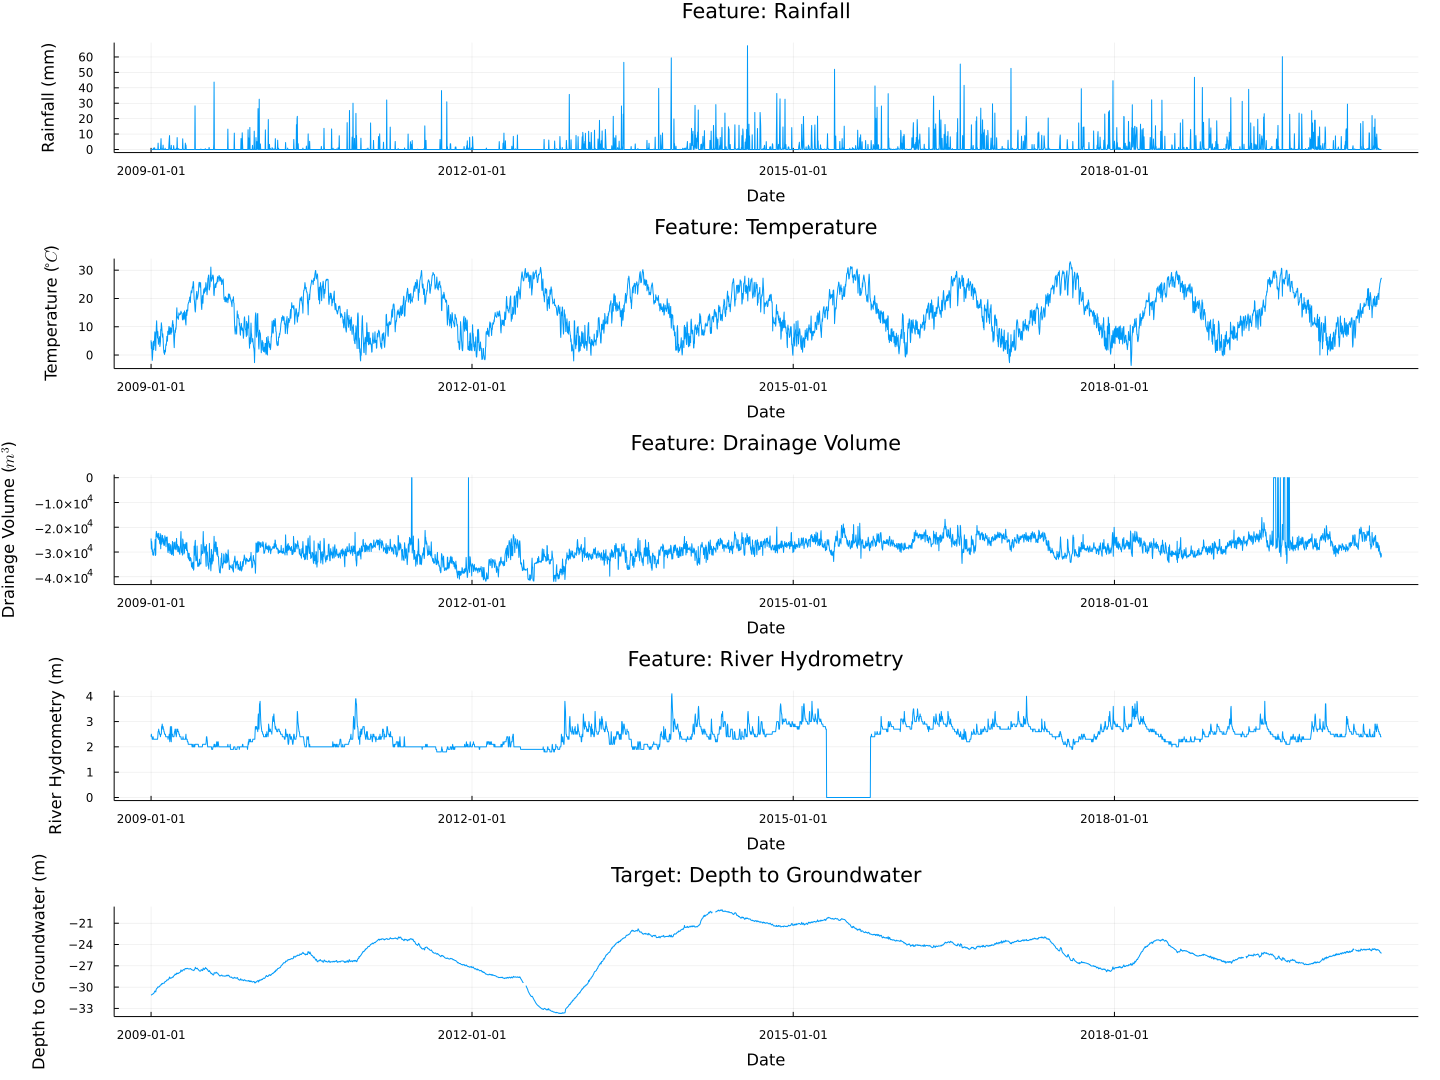

In [4]:
p1 = plot(df.Date, df.Rainfall, xlabel="Date", ylabel="Rainfall (mm)", title="Feature: Rainfall", legend = false)
p2 = plot(df.Date, df.Temperature, xlabel="Date", ylabel=L"Temperature ($\degree C$)", title="Feature: Temperature", legend = false)
p3 = plot(df.Date, df.Drainage_Volume, xlabel="Date", ylabel=L"Drainage Volume ($m^3$)", title="Feature: Drainage Volume", legend = false)
p4 = plot(df.Date, df.River_Hydrometry, xlabel="Date", ylabel="River Hydrometry (m)", title="Feature: River Hydrometry", legend = false)
p5 = plot(df.Date, df.Depth_to_Groundwater, xlabel="Date", ylabel="Depth to Groundwater (m)", title="Target: Depth to Groundwater", legend = false)

plot(p1, p2, p3, p4, p5, layout=(5, 1), size=(1440, 1080), margin = 3.5 * Plots.mm)

## Data Preprocessing

### Chronological Order and Equidistant Timestamps

In [5]:
# Sort values by timestamp (not necessary in this case)
sort(df, :Date)

# Check time intervals
transform!(df, :Date => (x -> x - lag(x)) => :Time_Interval)
display(first(df[!, [:Date, :Time_Interval]], 5))
# https://stackoverflow.com/questions/63100620/any-better-equivalent-for-pandas-value-counts-in-julia-dataframes
display(combine(groupby(df, :Time_Interval), nrow))
select!(df, Not(:Time_Interval));

,Date,Time_Interval
,DateTime,Millisec…?
1,2009-01-01T00:00:00,missing
2,2009-01-02T00:00:00,86400000 milliseconds
3,2009-01-03T00:00:00,86400000 milliseconds
4,2009-01-04T00:00:00,86400000 milliseconds
5,2009-01-05T00:00:00,86400000 milliseconds


,Time_Interval,nrow
,Millisec…?,Int64
1,missing,1
2,86400000 milliseconds,4198


### Handling Implausible Zero Values

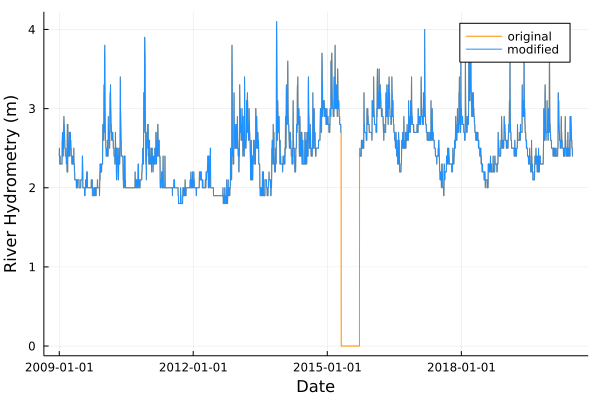

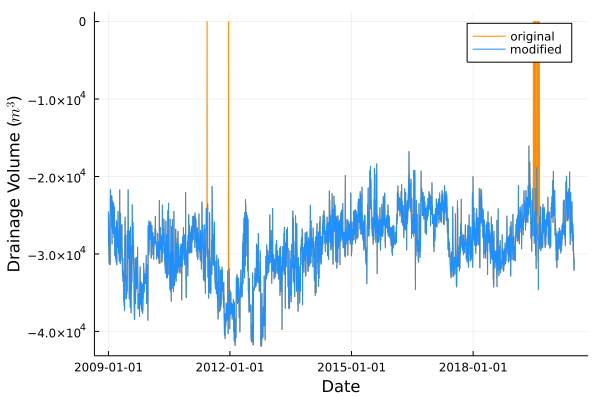

In [6]:
# Plot for obsveration
p = plot(df.Date, df.River_Hydrometry, color="darkorange", label="original")
plot!(p, df.Date, replace(df.River_Hydrometry, 0 => missing), color="dodgerblue", label="modified")
xlabel!(p, "Date")
display(ylabel!(p, "River Hydrometry (m)"))

p = plot(df.Date, df.Drainage_Volume, color="darkorange", label="original")
plot!(p, df.Date, replace(df.Drainage_Volume, 0 => missing), color="dodgerblue", label="modified")
xlabel!(p, "Date")
display(ylabel!(p, L"Drainage Volume ($m^3$)"))

# Replace 0 with missing in-place
replace!(df.River_Hydrometry, 0 => missing);
replace!(df.Drainage_Volume, 0 => missing);

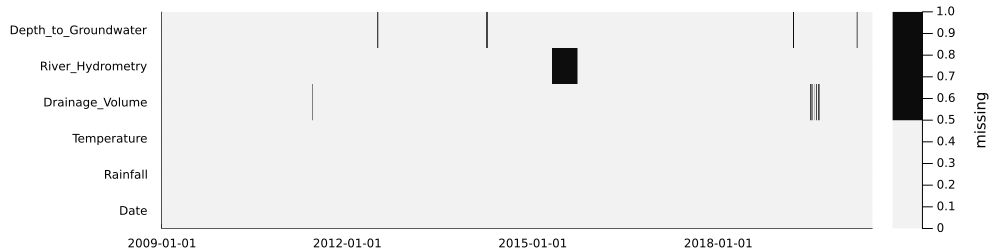

In [7]:
p = heatmap(df.Date, names(df), ismissing.(permutedims(Matrix(df))), color=palette(:grays, 2, rev=true), colorbar_title="missing", size=(1000, 250))

## Feature Engineering

### Time Features

In [8]:
@chain df begin
    select!(:Date => ByRow(x -> Year(x).value) => :year, :)
    select!(:Date => ByRow(x -> Month(x).value) => :month, :)
    select!(:Date => ByRow(x -> Day(x).value) => :day, :)
    select!(:Date => ByRow(dayofyear) => :day_of_year, :)
    select!(:Date => ByRow(week) => :week_of_year, :)
    select!(:Date => ByRow(quarterofyear) => :quarter, :)
    select!(:month => ByRow(x -> fld(x%12, 3) + 1) => :season, :)
    @aside display(first(df[!, [:Date, :year, :month, :day, :day_of_year, :week_of_year, :quarter, :season]], 5))
    select!([:year, :month, :day, :day_of_year, :week_of_year, :quarter, :season], Not(:Date))
    @aside display(first(_, 5))
end;

,Date,year,month,day,day_of_year,week_of_year,quarter,season
,DateTime,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,2009-01-01T00:00:00,2009,1,1,1,1,1,1
2,2009-01-02T00:00:00,2009,1,2,2,1,1,1
3,2009-01-03T00:00:00,2009,1,3,3,1,1,1
4,2009-01-04T00:00:00,2009,1,4,4,1,1,1
5,2009-01-05T00:00:00,2009,1,5,5,2,1,1


,year,month,day,day_of_year,week_of_year,quarter,season,Rainfall,Temperature,Drainage_Volume,River_Hydrometry,Depth_to_Groundwater
,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64?,Float64?,Float64?,Float64?,Float64?
1,2009,1,1,1,1,1,1,0.0,5.2,-24530.7,2.4,-31.14
2,2009,1,2,2,1,1,1,0.0,2.3,-28785.9,2.5,-31.11
3,2009,1,3,3,1,1,1,0.0,4.4,-25766.2,2.4,-31.07
4,2009,1,4,4,1,1,1,0.0,0.8,-27919.3,2.4,-31.05
5,2009,1,5,5,2,1,1,0.0,-1.9,-29854.7,2.3,-31.01


## Model: Decision Tree

### Time series as supervised learning problem: helper functions (A lot of hard code)

In [9]:
"""Transform a time series dataset into a supervised learning dataset"""
function series_to_supervised(data::Union{DataFrame, Matrix}; num_in=1, num_out=1, dropmissing=true)
    if isa(data, DataFrame)
        data = Array(data)
    end
    cols = []
    # input sequence (t-n, ... t-1)
    for i in range(num_in, 0, step=-1)
        push!(cols, Matrix(lag(data, i)))
    end
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, num_out, step=1)
        push!(cols, Matrix(lag(data, -i)))
    end
    # put it all together
    agg = cat(cols..., dims=2)
    # drop rows with missing values
    # https://stackoverflow.com/questions/65567382/analogue-of-pandas-dropna-in-julia
    if dropmissing
        agg = agg[all.(!ismissing, eachrow(agg)), :]
    end
    return DataFrame(convert(Matrix{Float64}, agg), :auto)
end

"""split a univariate dataset into train/test sets"""
function train_test_split(data, num_test)
    return data[1:end - num_test, :], data[end - num_test + 1:end, :]
end

"""Fit an Decision Tree model and make a one step prediction"""
function decision_tree_forecast(train, testX, model=nothing)
    if model == nothing
        model = (@load DecisionTreeRegressor pkg=DecisionTree verbosity=0)();
    end
    # transform array into dataframe
    train = DataFrame(train)
    # split into input and output columns
    trainX, trainy = train[:, 1:end-1], train[:, end]
    # fit model
    mach = machine(model, trainX, trainy)
    fit!(mach)
    # make a one-step prediction
    yhat = predict(mach, testX)
    return yhat
end

"""walk-forward validation for univariate data"""

function walk_forward_validation(data, num_test)
    predictions = Float64[]
    # split dataset
    train, test = train_test_split(data, num_test)
    # seed history with training dataset
    history = [x for x in eachrow(train)]
    # step over each time-step in the test set
    for i in 1:nrow(test)
        # split test row into input and output columns
        testX, testy = test[[i], 1:end-1], test[i, end]
        # fit model on history and make a prediction
        yhat = decision_tree_forecast(history, testX)
        # store forecast in list of predictions
        append!(predictions, yhat)
        # add actual observation to history for the next loop
        push!(history, test[i, :])
        # summarize progress
        @printf("Day %.0f  expected=%.1f  predicted=%.1f\n", i, testy, yhat[1])
    end
    # estimate prediction error
    error = mae(test[:, end], predictions)
    return error, test[:, end], predictions
end

walk_forward_validation (generic function with 1 method)

### Training models and forecasting next time step

Day 1  expected=-25.0  predicted=-24.8
Day 2  expected=-25.0  predicted=-25.0
Day 3  expected=-25.1  predicted=-25.1
Day 4  expected=-25.0  predicted=-25.0
Day 5  expected=-25.0  predicted=-25.1
Day 6  expected=-24.9  predicted=-25.0
Day 7  expected=-25.0  predicted=-24.9
Day 8  expected=-24.9  predicted=-25.0
Day 9  expected=-24.9  predicted=-24.8
Day 10  expected=-24.9  predicted=-24.8
Day 11  expected=-24.8  predicted=-25.0
Day 12  expected=-24.7  predicted=-24.6
Day 13  expected=-24.6  predicted=-24.4
Day 14  expected=-24.7  predicted=-24.5
Day 15  expected=-24.8  predicted=-24.6
Day 16  expected=-24.8  predicted=-24.6
Day 17  expected=-24.9  predicted=-24.6
Day 18  expected=-24.9  predicted=-24.9
Day 19  expected=-24.9  predicted=-24.9
Day 20  expected=-24.8  predicted=-24.9
Day 21  expected=-24.9  predicted=-24.8
Day 22  expected=-24.9  predicted=-24.9
Day 23  expected=-24.9  predicted=-24.9
Day 24  expected=-25.0  predicted=-24.9
Day 25  expected=-24.9  predicted=-24.9
Day 26  e

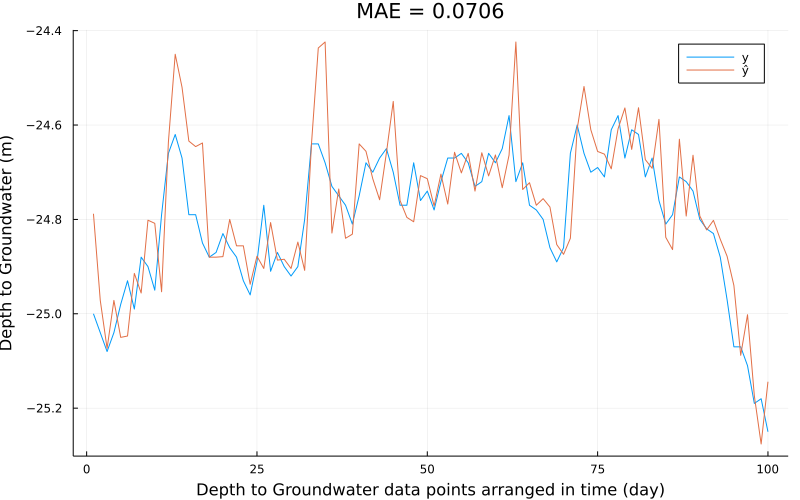

In [10]:
# transform the time series data into supervised learning
data = series_to_supervised(df, num_in=1);

with_logger(NullLogger()) do
    # Evaluate
    global loss, y, yhat = walk_forward_validation(data, 100)
end

plot(y, label="y", size=(800, 500))
plot!(yhat, label="ŷ")
xlabel!("Depth to Groundwater data points arranged in time (day)")
ylabel!("Depth to Groundwater (m)")
display(title!(@sprintf("MAE = %.4f", loss)))

### Training models and forecasting next 100 time step

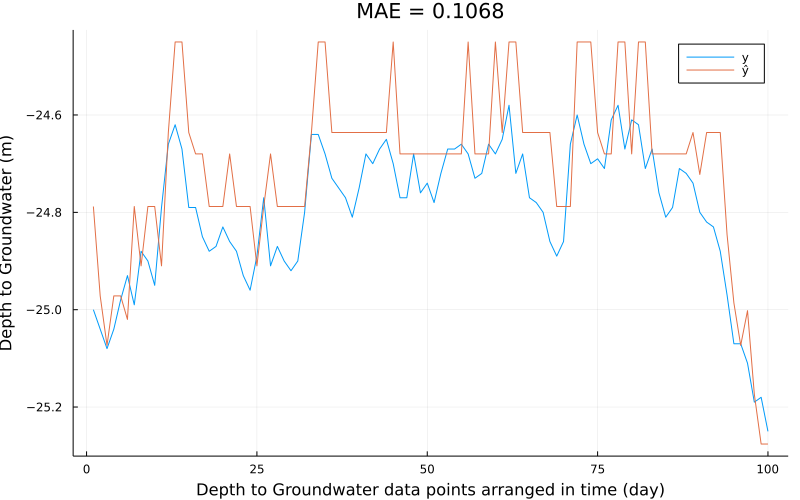

In [11]:
data = series_to_supervised(df, num_in=1)
train_data, test_data = train_test_split(data, 100)
with_logger(NullLogger()) do
    global yhat = decision_tree_forecast(train_data, test_data[:, 1:end-1]);
end

plot(test_data[:, end], label="y", size=(800, 500))
plot!(yhat, label="ŷ")
xlabel!("Depth to Groundwater data points arranged in time (day)")
ylabel!("Depth to Groundwater (m)")
display(title!(@sprintf("MAE = %.4f", mae(test_data[:, end], yhat))))

# References
- [Intro to Time Series Forecasting](https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting)
- [Forecasting Water Resources with Random Forest](https://www.kaggle.com/mixtek/forecasting-water-resources-with-random-forest#Random-Forest-Model)
- [Julia Data Science](https://juliadatascience.io/)
- [Data Science Tutorials in Julia](https://juliaai.github.io/DataScienceTutorials.jl/)
- [[MLJ]数据处理](https://discourse.juliacn.com/t/topic/4088)